# Fitting Data

## Author(s), contact(s), and dates:
- Author: Nan Normann Jakobsen
- Email:  nnj@chem.ku.dk
- Date:   18th of January 2023 (latest update)

In [1]:
import pandas as pd
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax   # Useful functions to print fit results on figure
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
import statistics 
from scipy import stats
from scipy.integrate import quad, dblquad
from sympy import *
from numpy.linalg import inv

## Problem 5.1

In [2]:
df = pd.read_csv('data_SignalDetection.csv', header = None)
display(df)
Index, Phase, Resonance, Frequency, Type = df.values.T

,0,1,2,3,4
0,1.0,2.5672,0.9417,3.5449,0.0
1,2.0,6.7571,2.0506,0.3735,0.0
2,3.0,6.5843,5.0052,0.0214,0.0
3,4.0,6.9203,6.0552,1.7828,0.0
4,5.0,9.1655,9.4412,0.4270,0.0
...,...,...,...,...,...
119995,119996.0,6.4552,7.0074,1.5217,-1.0
119996,119997.0,5.6248,3.9136,2.5539,-1.0
119997,119998.0,3.3970,1.8272,0.4577,-1.0
119998,119999.0,6.4059,2.5121,2.5542,-1.0


In [3]:
signal_mask = Type == 1
noise_mask = Type == 0
unknown_mask = Type == -1

dist_list = [Phase, Resonance, Frequency]
labels_list = ['Phase', 'Resonance', 'Frequency']

In [4]:
def plot_control(ax, Nbins, data, xlabel):
    # binwidth = (xmax - xmin) / Nbins
    ax.hist(data, bins=Nbins, histtype='step')
    ax.set(xlabel=xlabel, ylabel="Count")

### 5.1.1

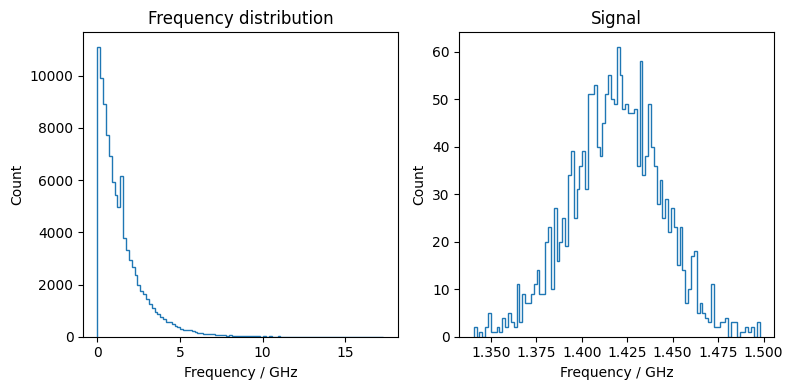

In [5]:
Nbins = 100

fig, ax = plt.subplots(1,2, figsize = (8, 4))

plot_control(ax[0], Nbins, Frequency[:100000], 'Frequency / GHz')
ax[0].set_title('Frequency distribution')
plot_control(ax[1], Nbins, Frequency[signal_mask], 'Frequency / GHz')
ax[1].set_title('Signal')

fig.tight_layout()
fig.savefig('frequency_distribution.png', dpi = 200)

In [6]:
def fit_gauss(x, N, mu, sigma):
    return N * stats.norm.pdf(x, loc = mu, scale = sigma)

fit_object = UnbinnedLH(fit_gauss, Frequency[signal_mask], extended=True)
minuit = Minuit(fit_object, N = 1000, mu = Frequency[signal_mask].mean(), sigma = Frequency[signal_mask].std(ddof=1))
minuit.errordef = 0.5
minuit.migrad()

c:\Users\nan25\OneDrive\Dokumenter\KU\5. år\AppStat\Exam\../External_Functions\ExternalFunctions.py:169: VisibleDeprecationWarning: make_func_code is deprecated: Use of `func_code` attribute to declare parameters is deprecated. Use `_parameters` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
C:\Users\nan25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\iminuit\util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.775e+04                 │              Nfcn = 59               │
│ EDM = 1.12e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  2.00e3   │  0.04e3   │            │            │         │         │       │
│ 1 │ mu    │  1.4188   │  0.0006   │            │            │         │         │       │
│ 2 │ sigma │  25.2e-3  │  0.4e-3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │         N        mu     sigma │
├───────┼───────────────────────────────┤
│     N │  2.01e+03  -7.74e-6 276.62e-6 │
│    mu │  -7.74e-6  3.25e-07        -0 │
│ sigma │ 276.62e-6        -0  1.78e-07 │
└───────┴───────────────────────────────┘

In [7]:
if (not minuit.fmin.is_valid) :                                   # Check if the fit converged!
    print("  WARNING: The unbinned likelihood fit DID NOT converge!!!")
minuit_output = [minuit.fmin, minuit.params]       # Save the output parameters in case needed
for name in minuit.parameters:
    print("  Unbinned LLH Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

  Unbinned LLH Fit result: N = 2003.75242 +/- 44.81002
  Unbinned LLH Fit result: mu = 1.41879 +/- 0.00057
  Unbinned LLH Fit result: sigma = 0.02523 +/- 0.00042


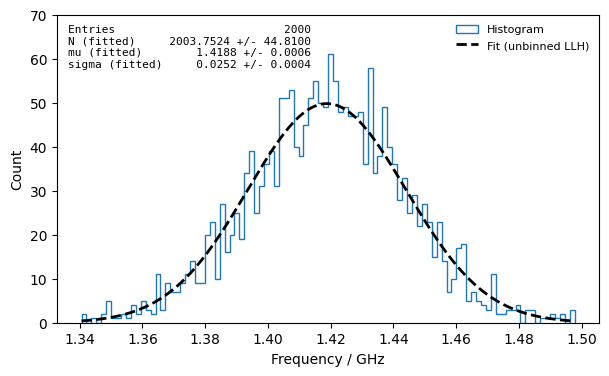

In [8]:
xmin, xmax= min(Frequency[signal_mask]), max(Frequency[signal_mask])
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(Frequency[signal_mask], bins=Nbins, range=(xmin, xmax), histtype='step', label='Histogram' )
# Plot fit result on top of histograms:
x_ulfit = np.linspace(xmin, xmax, 1000)                                    # Create the x-axis for the plot of the fitted function
y_ulfit = binwidth * fit_gauss(x_ulfit, *minuit.values)
ax.plot(x_ulfit, y_ulfit, '--', color='black', linewidth=2, label='Fit (unbinned LLH)')

ax.set(xlabel="Frequency / GHz", ylabel = "Count", ylim = (0,70))
ax.legend(frameon = False, fontsize = 8)

# Define figure text
d = {'Entries': len(Frequency[signal_mask]),
     'N (fitted)': [minuit.values[0], minuit.errors[0]],
     'mu (fitted)': [minuit.values[1], minuit.errors[1]],
     'sigma (fitted)': [minuit.values[2], minuit.errors[2]],
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=1, decimals=4)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=8)

fig.savefig('freq_control_peak.png', dpi = 200)

### 5.1.2

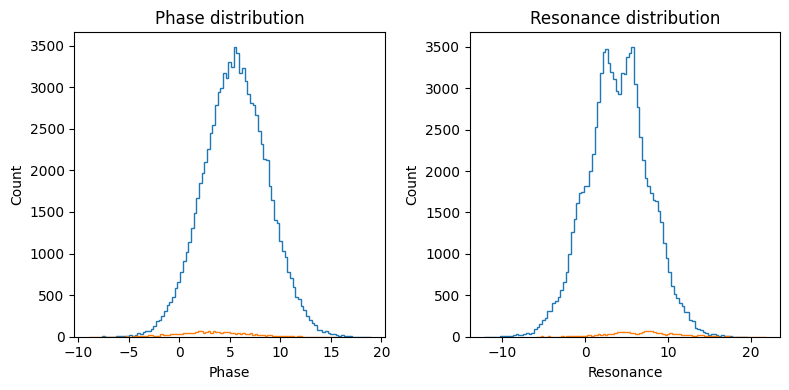

In [40]:
Nbins = 100

fig, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].hist(Phase[noise_mask], Nbins, histtype='step', label='Noise')
ax[0].hist(Phase[signal_mask], Nbins, histtype='step', label='Signal')
ax[0].set(title=('Phase distribution'), xlabel='Phase', ylabel='Count')

ax[1].hist(Resonance[noise_mask], Nbins, histtype='step', label='Noise')
ax[1].hist(Resonance[signal_mask], Nbins, histtype='step', label='Signal')
ax[1].set(title=('Resonance distribution'), xlabel='Resonance', ylabel='Count')

fig.tight_layout()
fig.savefig('P_R_distribution.png', dpi = 200)

In [10]:
covmat_noise = np.cov(Phase[noise_mask], Resonance[noise_mask])
covmat_signal = np.cov(Phase[signal_mask], Resonance[signal_mask])

noise_mean = np.array([Phase[noise_mask].mean(), Resonance[noise_mask].mean()])
signal_mean = np.array([Phase[signal_mask].mean(), Resonance[signal_mask].mean()])

In [11]:
# The calculations requires the inverted COMBINED covariance matrices:
print("Combined covariance matrix:")
covmat_comb = covmat_noise + covmat_signal
print(covmat_comb)

print("Inverted combined covariance matrix:")
covmat_comb_inv = inv(covmat_comb)
print(covmat_comb_inv)

wf = covmat_comb_inv.dot(noise_mean - signal_mean)
print('w:', wf)

Combined covariance matrix:
[[21.36433391 19.4519654 ]
 [19.4519654  30.17354934]]
Inverted combined covariance matrix:
[[ 0.11332413 -0.0730566 ]
 [-0.0730566   0.08023897]]
w: [ 0.47367704 -0.40118526]


In [36]:
noise = np.array([Phase[noise_mask], Resonance[noise_mask]])
signal = np.array([Phase[signal_mask], Resonance[signal_mask]])
w0 = -0.5 * np.dot(wf.T, (noise_mean + signal_mean))

fisher_data_noise = wf.dot(noise) + w0
fisher_data_signal = wf.dot(signal) + w0

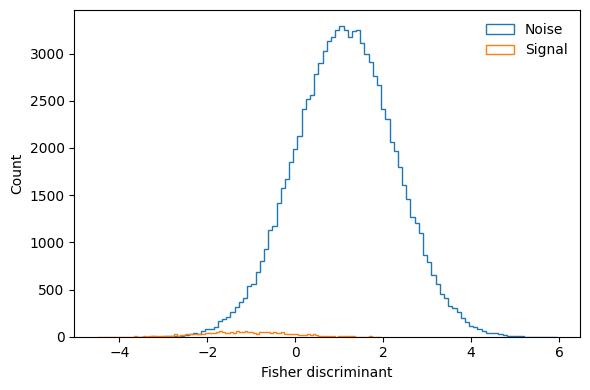

In [41]:
fig, ax = plt.subplots(figsize = (6,4))

ax.hist(fisher_data_noise, Nbins, histtype='step', label='Noise')
ax.hist(fisher_data_signal, Nbins, histtype='step', label='Signal')
ax.legend(frameon=False)

ax.set(xlabel='Fisher discriminant', ylabel='Count')

fig.tight_layout()
fig.savefig('Fisher.png', dpi=200)

In [113]:
frac_list = []

for fisher in np.linspace(-5, 6, 100):
    count_noise = 0
    for f in fisher_data_noise:
        if f > fisher:
            count_noise += 1

    count_signal = 0
    for f in fisher_data_signal:
        if f < fisher:
            count_signal += 1

    frac = (count_noise + count_signal) / (len(fisher_data_noise) + len(fisher_data_signal))
    frac_list.append(frac)

print(max(frac_list))
print(np.linspace(-5, 6, 100)[np.argmax(frac_list)])

0.98155
-2.111111111111111


### 5.1.3

### 5.1.4

In [14]:
freq_unknown = Frequency[unknown_mask]

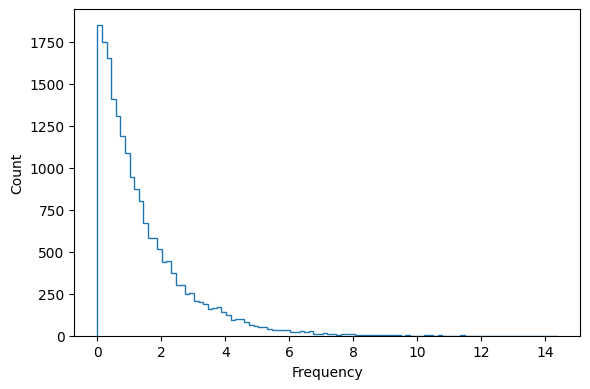

In [110]:
Nbins = 100

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(freq_unknown, Nbins, histtype = 'step')

ax.set(xlabel = 'Frequency', ylabel = 'Count')

fig.tight_layout()
fig.savefig('freq_unknown.png', dpi = 150)

In [74]:
freq_mask = freq_unknown <= 1.0
freq = freq_unknown[freq_mask]

freq_mask = freq >= 0.1
freq = freq[freq_mask]

In [92]:
counts, bin_edges = np.histogram(freq, bins=Nbins)
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts) 

In [93]:
# Define background PDF:
def exp_pdf(x, tau):
    """Exponential with lifetime tau"""
    return 1.0 / tau * np.exp(-x/tau)

# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * exp_pdf(x, tau) + Ngauss * binwidth * gauss_pdf(x, mu, sigma)

In [94]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(Nexp, tau, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x, Nexp, tau, Ngauss, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

minuit_chi2 = Minuit(chi2_owncalc, Nexp=10000, tau=2.9, Ngauss=1000, mu=0.2, sigma=0.1)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad();           # This is where the minimisation is carried out! Put ";" at the end to void output

In [95]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: Nexp = 3781.02232 +/- 200.99667
Fit value: tau = 1.62341 +/- 0.13333
Fit value: Ngauss = 39.48458 +/- 13.45571
Fit value: mu = 0.30996 +/- 0.01500
Fit value: sigma = 0.04519 +/- 0.01468
Chi2 value: 103.1   Ndof = 95    Prob(Chi2,Ndof) = 0.267


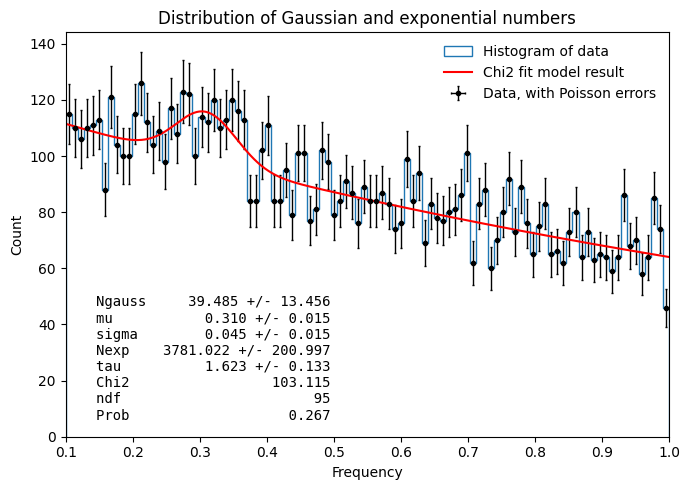

In [114]:
x_bg = np.linspace(0.1, 1, 1000)
y_bg = -50*x_bg + 108

fig, ax = plt.subplots(figsize = (7, 5))

ax.hist(freq, Nbins, histtype = 'step', label = 'Histogram of data')
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Frequency", # the label of the y axis
       ylabel="Count",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None], # Setting the miminum to zero
       xlim = (0.1, 1))
# Adding fit function to plot:
x_axis = np.linspace(0.1, 1, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 
ax.legend(frameon = False)

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Nexp':     [minuit_chi2.values['Nexp'], minuit_chi2.errors['Nexp']],
     'tau':         [minuit_chi2.values['tau'], minuit_chi2.errors['tau']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.35, text, ax, fontsize=10)

fig.tight_layout()
fig.savefig('freq_peak_unknown.png', dpi=200)

### 5.1.5

In [108]:
peak_entries = (minuit_chi2.values['Ngauss'] / minuit_chi2.values['Nexp']) * len(freq)

print('Estimated number of signal entries in peak:', peak_entries)

Estimated number of signal entries in peak: 92.77411198319153


In [109]:
significance = minuit_chi2.values['Ngauss'] / minuit_chi2.errors['Ngauss']

print('Significance of peak:', significance)

Significance of peak: 2.9344114879231835


### 5.1.6

In [17]:
def profile_x(x, y, bins, xyrange):
    
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=xyrange)
    x_center = 0.5*(xedges[1:] + xedges[:-1])
    y_center = 0.5*(yedges[1:] + yedges[:-1])
    
    wsums = H.sum(1)
    
    mask = wsums > 0
    
    mean = (H*y_center).sum(1)[mask] / wsums[mask]
    mean_squared = (H*y_center**2).sum(1)[mask] / wsums[mask]
    std = np.sqrt( mean_squared - mean**2 ) / np.sqrt(wsums[mask]) 

    return x_center[mask], mean, std

c:\Users\nan25\OneDrive\Dokumenter\KU\5. år\AppStat\Exam\../External_Functions\ExternalFunctions.py:113: VisibleDeprecationWarning: make_func_code is deprecated: Use of `func_code` attribute to declare parameters is deprecated. Use `_parameters` instead, which is a dict of parameter names to limits.
  self.func_code = make_func_code(describe(self.f)[1:])
C:\Users\nan25\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\iminuit\util.py:1297: VisibleDeprecationWarning: Using the `func_code` attribute to dynamically declare parameter names is deprecated, use the attribute `_parameters` instead (a dict of strings to limits)
  warnings.warn(
c:\Users\nan25\OneDrive\Dokumenter\KU\5. år\AppStat\Exam\../External_Functions\ExternalFunctions.py:121: RuntimeWarning: divide by zero encountered in divide
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)


Calibration fit result:
Fit value: p0 = 3.00000 +/- nan
Fit value: p1 = 0.60000 +/- nan


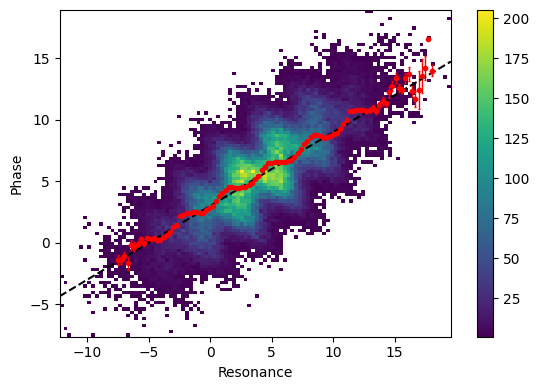

In [42]:
xmin_p, xmax_p = min(Phase[noise_mask]), max(Phase[noise_mask])
xmin_r, xmax_r = min(Resonance[noise_mask]), max(Resonance[noise_mask])
Nbins = 100

fig, ax = plt.subplots(figsize=(6, 4))
counts, xedges, yedges, im1 = ax.hist2d(Resonance[noise_mask], Phase[noise_mask], bins=[100, 100], cmin=1)

ax.set(xlabel='Resonance', 
       ylabel='Phase',
       aspect='equal', # NOTE: This forces the x- and y-axis to have the SAME scale!!!
      )

# 1D "profile" of the histogram to better see (and fit) any variation in RD with lsig:
x_center, mean, std = profile_x(Resonance[noise_mask], Phase[noise_mask], bins=(100,100), xyrange=[(xmin_p, xmax_p), (xmin_r, xmax_r)])
x_binwidth = x_center[1] - x_center[0]
ax.errorbar(x_center, mean, xerr=x_binwidth/2, yerr=std,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1)

# Fit for the effect from "lsig" on RD in the 1D graph:
def calibfit(x, p0, p1):
    return p0 + p1*x

chi2_object = Chi2Regression(calibfit, x_center, mean, std)
minuit = Minuit(chi2_object, p0=3, p1=0.6)
minuit.errordef = 1.0
minuit.migrad()

# Print fit result:
print("Calibration fit result:")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

# Draw the fit on top of the plot along with numbers for quantification:
x_fit = np.linspace(xmin_r, xmax_r, 1000)
y_fit = calibfit(x_fit, *minuit.values[:])
ax.plot(x_fit, y_fit, '--k')

fig.colorbar(im1) # ticks=[-1, 0, 1]

fig.tight_layout()
plt.savefig('Phase_vs_Res.png', dpi = 200)

In [43]:
# Phase_calib = Phase[:100000] - calibfit(Resonance[:100000], *minuit.values[:])
Resonance_calib = Resonance[noise_mask] - calibfit(Phase[noise_mask], *minuit.values[:])

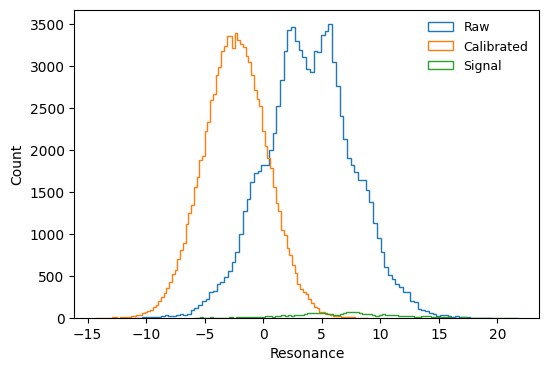

In [111]:
fig, ax = plt.subplots(figsize=(6,4))

# ax.hist(Resonance[:100000], Nbins, histtype='step', label='Full')
ax.hist(Resonance[noise_mask], Nbins, histtype='step', label = 'Raw')
ax.hist(Resonance_calib, Nbins, histtype='step', label='Calibrated')
ax.hist(Resonance[signal_mask], Nbins, histtype='step', label = 'Signal')
ax.legend(frameon=False, fontsize=9)

ax.set(xlabel='Resonance', ylabel='Count')

fig.tight_layout
fig.savefig('raw_calib.png', dpi = 200)

## Problem 5.2

In [22]:
df = pd.read_csv('data_DecayTimes.csv', header = None)
decay_times = df[0].values.T

### 5.2.1

In [23]:
t_mean, t_median, t_std = decay_times.mean(), statistics.median(decay_times), decay_times.std(ddof=1)
error_on_mean = t_std / np.sqrt(len(decay_times))

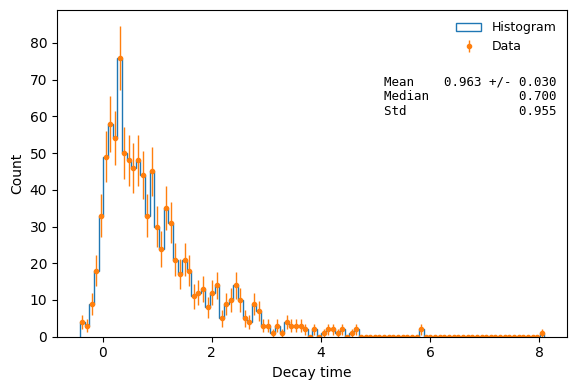

In [24]:
xmin = -1
xmax = 9
Nbins = 100
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(decay_times, Nbins, histtype = 'step', label = 'Histogram')

y, bin_edges = np.histogram(decay_times, bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=1, label="Data")

ax.legend(frameon = False, fontsize = 9)

d = {'Mean':   [t_mean, error_on_mean],
     'Median':   t_median,
     'Std':     t_std,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.64, 0.8, text, ax, fontsize=9)

ax.set(xlabel = 'Decay time', ylabel = 'Count')

fig.tight_layout()
fig.savefig('decay_times.png', dpi = 150)

### 5.2.2

In [25]:
mask_fit1 = decay_times > 3

In [26]:
Minuit.print_level = 0

xmin2 = 4
xmax2 = max(decay_times)
binwidth = (xmax2 - xmin2) / Nbins

y, bin_edges = np.histogram(decay_times[mask_fit1], bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
ey = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [27]:
def fit_func(x, N, tau):
    return N * np.exp(-x / tau)

def chi2_owncalc(N, tau) :
    y_fit = fit_func(x, N, tau)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_owncalc.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_owncalc, N = 100, tau = 1) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_fit)
print(Prob_fit)

5.530184936106069
0.9999668045831218


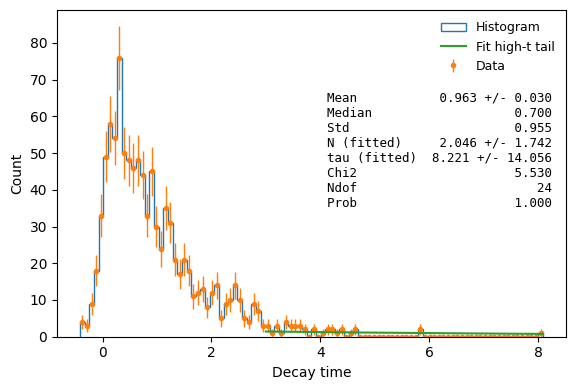

In [28]:
xmin = 3
xmax = max(decay_times)
x_val = np.linspace(xmin, xmax, 1000)
Nbins = 100
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(decay_times, Nbins, histtype = 'step', label = 'Histogram')
y, bin_edges = np.histogram(decay_times, bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=1, label="Data")

ax.plot(x_val, fit_func(x_val, *minuit.values), label = 'Fit high-t tail', zorder = 10)

ax.legend(frameon = False, fontsize = 9)

d = {'Mean':   [t_mean, error_on_mean],
     'Median':   t_median,
     'Std':     t_std,
     'N (fitted)': [minuit.values[0], minuit.errors[0]],
     'tau (fitted)': [minuit.values[1], minuit.errors[1]],
     'Chi2': Chi2_fit,
     'Ndof': Ndof_fit,
     'Prob': Prob_fit
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.53, 0.75, text, ax, fontsize=9)

ax.set(xlabel = 'Decay time', ylabel = 'Count')

fig.tight_layout()
fig.savefig('decay_times_fit1.png', dpi = 150)

### 5.2.3

In [29]:
xmin3 = min(decay_times)
binwidth = (xmax2 - xmin3) / Nbins

y, bin_edges = np.histogram(decay_times, bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
ey = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [30]:
def fit_func(x, N, tau):
    return N * np.exp(-x / tau)

def chi2_owncalc(N, tau) :
    y_fit = fit_func(x, N, tau)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_owncalc.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_owncalc, N = 100, tau = 1) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_fit)
print(Prob_fit)

573.9219586986464
1.7762750906624128e-86


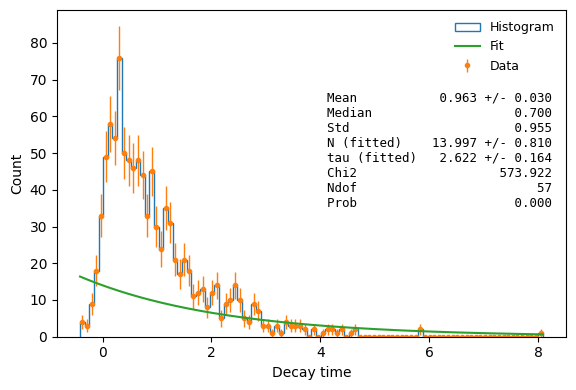

In [31]:
x_val = np.linspace(xmin3, xmax2, 1000)
Nbins = 100
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(decay_times, Nbins, histtype = 'step', label = 'Histogram')
y, bin_edges = np.histogram(decay_times, bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=1, label="Data")

ax.plot(x_val, fit_func(x_val, *minuit.values), label = 'Fit', zorder = 10)

ax.legend(frameon = False, fontsize = 9)

d = {'Mean':   [t_mean, error_on_mean],
     'Median':   t_median,
     'Std':     t_std,
     'N (fitted)': [minuit.values[0], minuit.errors[0]],
     'tau (fitted)': [minuit.values[1], minuit.errors[1]],
     'Chi2': Chi2_fit,
     'Ndof': Ndof_fit,
     'Prob': Prob_fit
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.53, 0.75, text, ax, fontsize=9)

ax.set(xlabel = 'Decay time', ylabel = 'Count')

fig.tight_layout()
fig.savefig('decay_times_fit2.png', dpi = 150)

In [32]:
mask_fit3 = decay_times > 0
xmin4 = 0
binwidth = (xmax2 - xmin4) / Nbins

y, bin_edges = np.histogram(decay_times[mask_fit3], bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
ey = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!

non_zero_mask = y != 0

y = y[non_zero_mask]
ey = ey[non_zero_mask]
x = x[non_zero_mask]

In [33]:
def fit_func(x, N, tau):
    return N * np.exp(-x / tau)

def chi2_owncalc(N, tau) :
    y_fit = fit_func(x, N, tau)
    chi2 = np.sum(((y - y_fit) / ey)**2)
    return chi2
chi2_owncalc.errordef = 1.0

# Here we let Minuit know, what to minimise, how, and with what starting parameters:   
minuit = Minuit(chi2_owncalc, N = 100, tau = 1) # initial guess

# Perform the actual fit:
minuit.migrad()

Nvar = 2                    # Number of variables
Ndof_fit = len(y) - Nvar    # Number of degrees of freedom = Number of data points - Number of variables

# Get the minimal value obtained for the quantity to be minimised (here the Chi2)
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

print(Chi2_fit)
print(Prob_fit)

73.28170538429525
0.050242654406618535


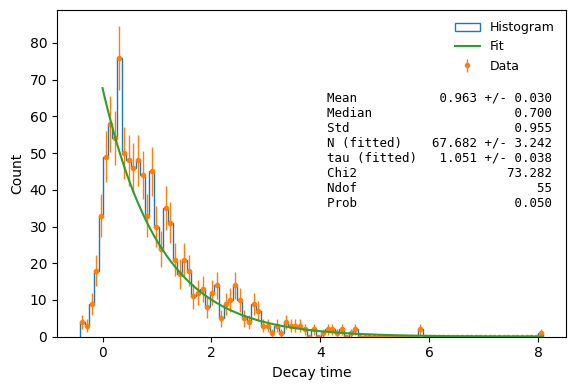

In [34]:
x_val = np.linspace(xmin4, xmax2, 1000)
Nbins = 100
binwidth = (xmax - xmin) / Nbins

fig, ax = plt.subplots(figsize = (6, 4))

ax.hist(decay_times, Nbins, histtype = 'step', label = 'Histogram')
y, bin_edges = np.histogram(decay_times, bins=Nbins)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - bin entries are Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=1, label="Data")

ax.plot(x_val, fit_func(x_val, *minuit.values), label = 'Fit', zorder = 10)

ax.legend(frameon = False, fontsize = 9)

d = {'Mean':   [t_mean, error_on_mean],
     'Median':   t_median,
     'Std':     t_std,
     'N (fitted)': [minuit.values[0], minuit.errors[0]],
     'tau (fitted)': [minuit.values[1], minuit.errors[1]],
     'Chi2': Chi2_fit,
     'Ndof': Ndof_fit,
     'Prob': Prob_fit
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.53, 0.75, text, ax, fontsize=9)

ax.set(xlabel = 'Decay time', ylabel = 'Count')

fig.tight_layout()
fig.savefig('decay_times_fit3.png', dpi = 150)